## 0) Import Libraries and General Script

In [62]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
#import cobra
#from cobra.io import load_model
import pandas as pd
from tqdm import tqdm

# Parameters (Feeding point)
x_feed, y_feed, z_feed = 1.15, 10.24, 0.15     #m

# Monod Kinetics (Modeling of Overflow Metabolism in Batch and Fed-Batch Cultures of Escherichia coli)
# (Lin et.al. 2000)
q_S_max = 1.5     # gS/gX/h
K_S = 0.03         # g/L

# Define seaborn theme
sns.set_theme()
sns.set_context('paper')
# Set the Seaborn color palette
sns.set_palette("colorblind")

# Define scientific formatter in matplotlib
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-1,1))
formatter.format = '%.1e'

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import pandas as pd

# dFBA - CFD Lifeline
## 1) Introduction
This jupyter notebook shows how it is possible to combine data coming from CFD simulations with metabolic modeling, specifically dFBA (Dynamic Flux Balance Analysis).

### 1.1) Cell-Lifelines 
First we have to solve the **general micro-balances** for momentum and mass using Computational Fluid Dynamics (Fluent):

$$
\begin{aligned}
&\text{Continuity Equation:}\quad\nabla\cdot\rho U + \frac{\partial \rho}{\partial t} = 0 \\
&\text{Navier-Stokes:}\quad\frac{\partial}{\partial t}\left(\rho U\right)+\nabla\cdot\left(\rho U \otimes U\right) = - \nabla P + \mu \nabla^2+\frac{1}{3}\mu\nabla\left(\nabla\cdot U\right) + \rho g \\
&\text{Mass Balance:}\quad\frac{\partial C_i}{\partial t} + \left(U \cdot \nabla\right)C_i = \mathcal{D}\nabla^2 C_i + r_i
\end{aligned}
$$

**Eulerian Specification of Fluid Flow:**

Field is represented as function of position $x$ and time $t$. **Flow velocity** is represented by the function:
$$
u\left(x,t\right)
$$

**Lagrangian Specification of Fluid Flow:**

Individual **fluid parcels** are followed through time. The fluid parcels (**cells** in our case) are labeled by some (time-independent) vector field $x_0$ (position of the center of mass of parcels at time $t_0$). In the Lagrangian description, the flow is described by a function:
$$
X(x_0,t)
$$
The two specifications are related as follows:
$$
u\left(X\left(x_0,t\right),t\right) = \frac{\partial X}{\partial t}\left(x_0, t\right)
$$
Because both sides describe the velocity of the particle labeled $x_0$ at time $t$.

The **important assumptions** to track **cell lifelines** are:
* Parcels have same density as the broth.
* Parcels have same velocity as fluid flows.
* No boundary layer around the cell.

Load data from the lifelines and plot environment seen by the cell

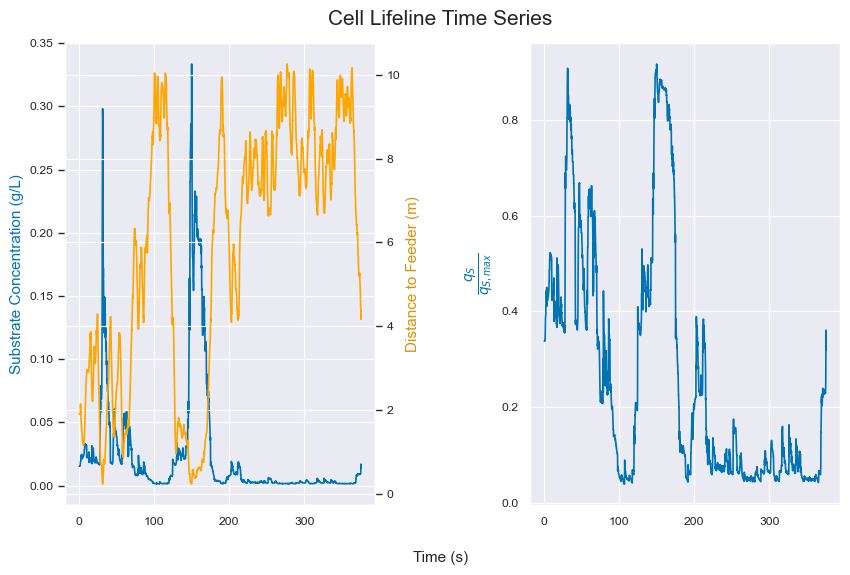

In [2]:
# Load data
delta_t = 0.1      # s
data = np.loadtxt("lifeline_0.out", delimiter=",")
x_array, y_array, z_array, C_S_array = data[:, 0], data[:, 1], data[:, 2], data[:, 3]
time_array = np.arange(0, len(C_S_array)*delta_t, delta_t)

# Compute distance to feeding point
dist_feed_point = np.sqrt((x_array-x_feed)**2 + (y_array-y_feed)**2 + (z_array-z_feed)**2)

# Plot environment seen by the cell and the distance to the feeding point
fig, ax = plt.subplots(1, 2, figsize=(10,6))
sns.lineplot(x=time_array, y=C_S_array, ax=ax[0])
ax[0].set_ylabel("Substrate Concentration (g/L)", fontsize=11,
              color=sns.color_palette()[0])
# Create a second y-axis on the right side 
ax2 = ax[0].twinx()
sns.lineplot(x=time_array, y=dist_feed_point, color='orange', ax=ax2)
ax2.set_ylabel("Distance to Feeder (m)", fontsize=11,
              color=sns.color_palette()[1])

# Plot log10(qS/qSmax) vs time and dist to feed point
q_S= q_S_max*C_S_array/(K_S+C_S_array)
qS_qSmax = q_S/q_S_max
log10_qS_qSmax = np.log10(qS_qSmax)

#plt.title("Cell Lifeline Time Series", fontsize=14)
sns.lineplot(x=time_array, y=qS_qSmax, ax=ax[1])
ax[1].set_ylabel("$\\frac{q_S}{q_{S,max}}$", fontsize=14,
                color=sns.color_palette()[0])
#ax2 = ax[1].twinx()
#sns.lineplot(x=time, y=dist_feed_point, color='orange', ax=ax2)
#ax2.set_ylabel("Distance to Feeder (m)", fontsize=11,
#              color=sns.color_palette()[1])

# Common x-label
fig.supxlabel("Time (s)", fontsize=11)

# Space between subplots
fig.subplots_adjust(wspace=0.5)

# Title
fig.suptitle("Cell Lifeline Time Series", fontsize=15, y=0.935)

plt.show()


### 1.2) dFBA


In [11]:
import cobra
from cobra.io import load_model
import numpy as np

# Monod Kinetics (Modeling of Overflow Metabolism in Batch and Fed-Batch Cultures of Escherichia coli)
# (Lin et.al. 2000)
q_S_max = 1.5     # gS/gX/h
K_S = 0.03         # g/L

def lexicographic_dFBA(C_S: float, model=load_model("textbook")):
    # Re-build model
    model = load_model("textbook")
    
    # Change solver --> When we have cplex cplex, by now glpk
    model.solver = 'glpk'
    
    # Add glucose import as a constraint wih monod
    glucose_max_import = - q_S_max * C_S / (K_S + C_S)
    model.reactions.EX_glc__D_e.lower_bound = glucose_max_import
    
    # 1) Optimize aux-LP to get only feasible solutions
    cobra.util.solver.add_lp_feasibility(model)
    error = model.slim_optimize()
    # Establish feasibility objective as constraint
    cobra.util.fix_objective_as_constraint(model)
    
    # 2) Optimize the Biomass --> Import glucose in Lexicographic form and optimize for qS
    lex_constraints = cobra.util.add_lexicographic_constraints(model, 
                                    ['Biomass_Ecoli_core', 'EX_glc__D_e'], ['max', 'min'])
    
    # 3) Solve model and compute fluxes
    solution = model.optimize()
    fluxes = np.array(model.optimize().fluxes.tolist())
    
    return model, solution, error
    

Solve dFBA with C_S from the lifelines

In [7]:
# Build model
model = load_model("textbook")

# Initialize pd.df solution
fluxes_df = pd.DataFrame(columns=[reaction.id for reaction in model.reactions], index=time_array,)
fluxes_df.index.name = "Time (s)"
errors = []

# Solve dFBA for the cell lifeline
for i in tqdm(range(0,len(time_array))):
    # Call function to solve dFBA
    mode, solution, error = lexicographic_dFBA(C_S=C_S_array[i], model=model)
    
    # Store solution in a pd.df
    fluxes_df.loc[time_array[i]] = solution.fluxes.to_dict()
    
    # Store errors
    errors.append(error)
    
# Include Error as new column in the data frame
fluxes_df['Error'] = errors

# Store pd.df as csv file
fluxes_df.to_csv("dFBA_Textbook_Model_Reaction_Fluxes.csv", sep="\t", header=True, index=True)


100%|██████████| 3756/3756 [29:36<00:00,  2.11it/s]


# Training on One Lifeline 

In [64]:
import os
import pandas as pd
import numpy as np

folder_path = 'dFBA_Data_Frames_Lifelines - Small'
file_names = sorted(os.listdir(folder_path))

expected_timepoints = 376

for file_name in file_names:
    file_path = os.path.join(folder_path, file_name)
    lifeline_df = pd.read_csv(file_path, sep="\t", index_col=0)

    # Select every 10th row and ensure there are exactly 376 timepoints
    reduced_df = lifeline_df.iloc[::10][:expected_timepoints]
    reduced_df.to_csv(file_path, sep="\t")

data_list = []
filtered_reactions = None

for file_name in file_names:
    file_path = os.path.join(folder_path, file_name)
    lifeline_df = pd.read_csv(file_path, sep="\t", index_col=0)

    if filtered_reactions is None:
        non_constant_fluxes_df = lifeline_df.loc[:, (lifeline_df != lifeline_df.iloc[0]).any()]
        unique_reactions_fluxes_df = non_constant_fluxes_df.loc[:, ~non_constant_fluxes_df.columns.duplicated()]
        filtered_reactions = unique_reactions_fluxes_df.columns

    filtered_lifeline_df = lifeline_df[filtered_reactions]

    if filtered_lifeline_df.shape != (expected_timepoints, len(filtered_reactions)):
        print(f"Shape mismatch for file: {file_name}. Expected ({expected_timepoints}, {len(filtered_reactions)}) but got {filtered_lifeline_df.shape}")

    data_list.append(filtered_lifeline_df.to_numpy())

data_3d = np.stack(data_list, axis=1)
print("Shape of the Big Matrix:", data_3d.shape)


C:\Users\elysi\AppData\Local\Temp\ipykernel_26220\1613520054.py:15: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  reduced_df = lifeline_df.iloc[::10][:expected_timepoints]
C:\Users\elysi\AppData\Local\Temp\ipykernel_26220\1613520054.py:15: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  reduced_df = lifeline_df.iloc[::10][:expected_timepoints]
C:\Users\elysi\AppData\Local\Temp\ipykernel_26220\1613520054.py:15: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  reduced_df = lifeline_df.iloc[::10][:expecte

Shape of the Big Matrix: (376, 14, 48)


In [65]:
one_lifeline = data_3d[:,0:1,:]
# Transpose one_lifeline to (1,376, 48) 
one_lifeline = one_lifeline.transpose(1,0,2)

In [66]:
one_lifeline.shape

(1, 376, 48)

In [20]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, RepeatVector, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional

# Define the autoencoder model using Sequential
autoencoder = Sequential()

# Encoder
autoencoder.add(LSTM(120, activation='tanh', kernel_initializer='he_uniform', input_shape=(376, 48), return_sequences=False))
autoencoder.add(Dense(40, activation='tanh'))  # This layer acts as the latent representation

# Decoder
autoencoder.add(RepeatVector(376))
autoencoder.add(LSTM(120, activation='tanh', return_sequences=True))
autoencoder.add(LSTM(48, activation='linear', return_sequences=True))  # Reconstructing the original input

# Learning rate
initial_learning_rate = 0.0001

# Optimizer
optimizer = Adam(learning_rate=initial_learning_rate)

# Compile the model
autoencoder.compile(optimizer=optimizer, loss='mse')

# Summary of the model
autoencoder.summary()




Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 120)               81120     
                                                                 
 dense_2 (Dense)             (None, 40)                4840      
                                                                 
 repeat_vector_2 (RepeatVec  (None, 376, 40)           0         
 tor)                                                            
                                                                 
 lstm_7 (LSTM)               (None, 376, 120)          77280     
                                                                 
 lstm_8 (LSTM)               (None, 376, 48)           32448     
                                                                 
Total params: 195688 (764.41 KB)
Trainable params: 195688 (764.41 KB)
Non-trainable params: 0 (0.00 Byte)
______________

In [21]:
# Directly using one_lifeline for both training and validation as a placeholder
train_data = one_lifeline
val_data = one_lifeline

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Since we don't have multiple sequences, use the whole sequence for both training and validation
history = autoencoder.fit(train_data, train_data, epochs=15, validation_data=(val_data, val_data), callbacks=[reduce_lr, early_stop])

# Predict on the validation set
val_predictions = autoencoder.predict(val_data)

# Compute mean squared error on the validation set
mean_squared_error = np.mean(np.square(val_data - val_predictions))

# Compute root mean squared error (RMSE)
reconstruction_loss = np.sqrt(mean_squared_error)
print(f"Validation RMSE: {reconstruction_loss}")

Epoch 1/15
1/1 [==============================] - 6s 6s/step - loss: 3.9511 - val_loss: 3.9189 - lr: 1.0000e-04
Epoch 2/15
1/1 [==============================] - 0s 375ms/step - loss: 3.9189 - val_loss: 3.8871 - lr: 1.0000e-04
Epoch 3/15
1/1 [==============================] - 0s 349ms/step - loss: 3.8871 - val_loss: 3.8561 - lr: 1.0000e-04
Epoch 4/15
1/1 [==============================] - 0s 363ms/step - loss: 3.8561 - val_loss: 3.8254 - lr: 1.0000e-04
Epoch 5/15
1/1 [==============================] - 0s 383ms/step - loss: 3.8254 - val_loss: 3.7944 - lr: 1.0000e-04
Epoch 6/15
1/1 [==============================] - 0s 371ms/step - loss: 3.7944 - val_loss: 3.7633 - lr: 1.0000e-04
Epoch 7/15
1/1 [==============================] - 0s 399ms/step - loss: 3.7633 - val_loss: 3.7322 - lr: 1.0000e-04
Epoch 8/15
1/1 [==============================] - 0s 335ms/step - loss: 3.7322 - val_loss: 3.7011 - lr: 1.0000e-04
Epoch 9/15
1/1 [==============================] - 0s 382ms/step - loss: 3.7011 - va

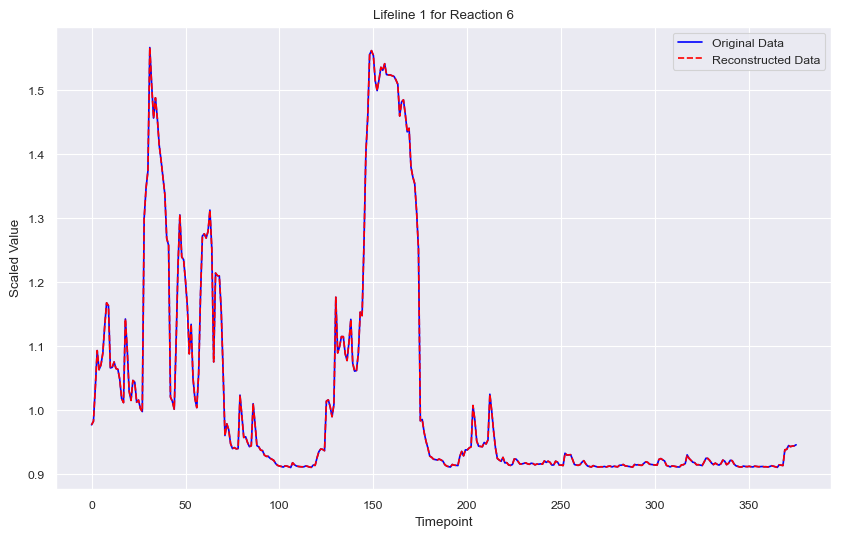

In [27]:
import matplotlib.pyplot as plt

# Choose a specific lifeline and reaction for plotting
lifeline_index = 0  # Index for lifeline 0 (assuming lifelines are zero-indexed)
reaction_index = 6 # Reaction index

# Extract series for plotting
scaled_series = one_lifeline[lifeline_index, :, reaction_index]
reconstructed_series = one_lifeline[lifeline_index, :, reaction_index]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(scaled_series, label='Original Data', color='blue')
plt.plot(reconstructed_series, label='Reconstructed Data', color='red', linestyle='--')
plt.title(f'Lifeline {lifeline_index + 1} for Reaction {reaction_index}')
plt.xlabel('Timepoint')
plt.ylabel('Scaled Value')
plt.legend()
plt.show()

# One Lifeline (Scaled)

In [28]:
import os
import pandas as pd
import numpy as np

folder_path = 'dFBA_Data_Frames_Lifelines - Small'
file_names = sorted(os.listdir(folder_path))

expected_timepoints = 376

for file_name in file_names:
    file_path = os.path.join(folder_path, file_name)
    lifeline_df = pd.read_csv(file_path, sep="\t", index_col=0)

    # Select every 10th row and ensure there are exactly 376 timepoints
    reduced_df = lifeline_df.iloc[::10][:expected_timepoints]
    reduced_df.to_csv(file_path, sep="\t")

data_list = []
filtered_reactions = None

for file_name in file_names:
    file_path = os.path.join(folder_path, file_name)
    lifeline_df = pd.read_csv(file_path, sep="\t", index_col=0)

    if filtered_reactions is None:
        non_constant_fluxes_df = lifeline_df.loc[:, (lifeline_df != lifeline_df.iloc[0]).any()]
        unique_reactions_fluxes_df = non_constant_fluxes_df.loc[:, ~non_constant_fluxes_df.columns.duplicated()]
        filtered_reactions = unique_reactions_fluxes_df.columns

    filtered_lifeline_df = lifeline_df[filtered_reactions]

    if filtered_lifeline_df.shape != (expected_timepoints, len(filtered_reactions)):
        print(f"Shape mismatch for file: {file_name}. Expected ({expected_timepoints}, {len(filtered_reactions)}) but got {filtered_lifeline_df.shape}")

    data_list.append(filtered_lifeline_df.to_numpy())

data_3d = np.stack(data_list, axis=1)
print("Shape of the Big Matrix:", data_3d.shape)


C:\Users\elysi\AppData\Local\Temp\ipykernel_26220\4099083542.py:15: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  reduced_df = lifeline_df.iloc[::10][:expected_timepoints]
C:\Users\elysi\AppData\Local\Temp\ipykernel_26220\4099083542.py:15: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  reduced_df = lifeline_df.iloc[::10][:expected_timepoints]
C:\Users\elysi\AppData\Local\Temp\ipykernel_26220\4099083542.py:15: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  reduced_df = lifeline_df.iloc[::10][:expecte

Shape of the Big Matrix: (376, 14, 48)


In [29]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# Assuming data_3d is original data with shape (n_timesteps, n_samples, n_features)
# Example: n_timesteps = 376, n_samples = 14, n_features = 48

n_timesteps, n_samples, n_features = data_3d.shape

# Initialize a StandardScaler for each feature for each sample
scalers = [[StandardScaler() for _ in range(n_features)] for _ in range(n_samples)]

# Normalized data will have the same shape as data_3d initially
normalized_data = np.empty_like(data_3d, dtype=float)

# Apply the scalers to each feature for each sample across all timesteps
for sample_index in range(n_samples):
    for feature_index in range(n_features):
        # Extract the feature data for the current sample
        feature_data = data_3d[:, sample_index, feature_index].reshape(-1, 1)
        
        # Fit and transform the data using the corresponding scaler
        normalized_feature_data = scalers[sample_index][feature_index].fit_transform(feature_data)
        
        # Assign the normalized data back to its position in the normalized_data array
        normalized_data[:, sample_index, feature_index] = normalized_feature_data.flatten()

# Transpose normalized_data to have the shape (n_samples, n_timesteps, n_features)
normalized_data = np.transpose(normalized_data, (1, 0, 2))

print("Shape of the Normalized Data:", normalized_data.shape)


Shape of the Normalized Data: (14, 376, 48)


In [34]:
one_lifeline = normalized_data[0:1, :, :]
# Transpose one_lifeline to (1,376, 48) 
#one_lifeline = one_lifeline.transpose(1,0,2)

In [35]:
one_lifeline.shape

(1, 376, 48)

In [36]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, RepeatVector, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional

# Define the autoencoder model using Sequential
autoencoder = Sequential()

# Encoder
autoencoder.add(LSTM(120, activation='tanh', kernel_initializer='he_uniform', input_shape=(376, 48), return_sequences=False))
autoencoder.add(Dense(40, activation='tanh'))  # This layer acts as the latent representation

# Decoder
autoencoder.add(RepeatVector(376))
autoencoder.add(LSTM(120, activation='tanh', return_sequences=True))
autoencoder.add(LSTM(48, activation='linear', return_sequences=True))  # Reconstructing the original input

# Learning rate
initial_learning_rate = 0.0001

# Optimizer
optimizer = Adam(learning_rate=initial_learning_rate)

# Compile the model
autoencoder.compile(optimizer=optimizer, loss='mse')

# Summary of the model
autoencoder.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 120)               81120     
                                                                 
 dense_3 (Dense)             (None, 40)                4840      
                                                                 
 repeat_vector_3 (RepeatVec  (None, 376, 40)           0         
 tor)                                                            
                                                                 
 lstm_10 (LSTM)              (None, 376, 120)          77280     
                                                                 
 lstm_11 (LSTM)              (None, 376, 48)           32448     
                                                                 
Total params: 195688 (764.41 KB)
Trainable params: 195688 (764.41 KB)
Non-trainable params: 0 (0.00 Byte)
______________

In [37]:
# Directly using one_lifeline for both training and validation as a placeholder
train_data = one_lifeline
val_data = one_lifeline

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Since we don't have multiple sequences, use the whole sequence for both training and validation
history = autoencoder.fit(train_data, train_data, epochs=15, validation_data=(val_data, val_data), callbacks=[reduce_lr, early_stop])

# Predict on the validation set
val_predictions = autoencoder.predict(val_data)

# Compute mean squared error on the validation set
mean_squared_error = np.mean(np.square(val_data - val_predictions))

# Compute root mean squared error (RMSE)
reconstruction_loss = np.sqrt(mean_squared_error)
print(f"Validation RMSE: {reconstruction_loss}")

Epoch 1/15
1/1 [==============================] - 6s 6s/step - loss: 1.0183 - val_loss: 1.0145 - lr: 1.0000e-04
Epoch 2/15
1/1 [==============================] - 0s 395ms/step - loss: 1.0145 - val_loss: 1.0114 - lr: 1.0000e-04
Epoch 3/15
1/1 [==============================] - 0s 378ms/step - loss: 1.0114 - val_loss: 1.0089 - lr: 1.0000e-04
Epoch 4/15
1/1 [==============================] - 0s 402ms/step - loss: 1.0089 - val_loss: 1.0070 - lr: 1.0000e-04
Epoch 5/15
1/1 [==============================] - 0s 406ms/step - loss: 1.0070 - val_loss: 1.0057 - lr: 1.0000e-04
Epoch 6/15
1/1 [==============================] - 0s 390ms/step - loss: 1.0057 - val_loss: 1.0047 - lr: 1.0000e-04
Epoch 7/15
1/1 [==============================] - 0s 402ms/step - loss: 1.0047 - val_loss: 1.0039 - lr: 1.0000e-04
Epoch 8/15
1/1 [==============================] - 0s 358ms/step - loss: 1.0039 - val_loss: 1.0034 - lr: 1.0000e-04
Epoch 9/15
1/1 [==============================] - 0s 402ms/step - loss: 1.0034 - va

In [41]:
import pandas as pd
from tensorflow.keras.models import Model

# Now, you'll create a new Sequential model for the encoder part
encoder_model = Sequential()

# Add encoder layers from the autoencoder model
for layer in autoencoder.layers[:2]:  # Assuming the first 2 layers are the encoder part
    encoder_model.add(layer)

# Now, `encoder_model` is effectively the encoder part of your autoencoder
# You can use it to predict latent representations
latent_reps = encoder_model.predict(normalized_data)

# Convert latent representations to a DataFrame
latent_reps_df = pd.DataFrame(latent_reps)

# Save to CSV
latent_reps_df.to_csv("latent_representations_one_lifeline.csv", index=False)


1/1 [==============================] - 0s 456ms/step


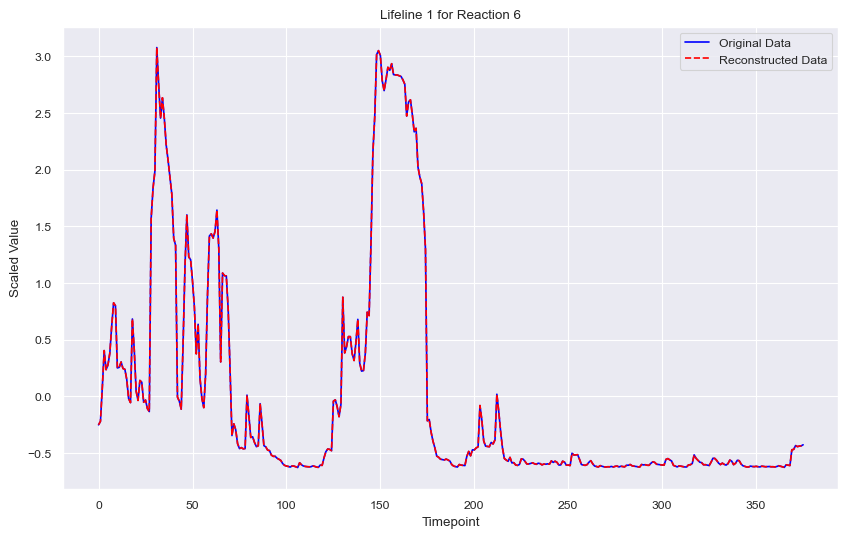

In [38]:
import matplotlib.pyplot as plt

# Choose a specific lifeline and reaction for plotting
lifeline_index = 0  # Index for lifeline 0 (assuming lifelines are zero-indexed)
reaction_index = 6 # Reaction index

# Extract series for plotting
scaled_series = one_lifeline[lifeline_index, :, reaction_index]
reconstructed_series = one_lifeline[lifeline_index, :, reaction_index]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(scaled_series, label='Original Data', color='blue')
plt.plot(reconstructed_series, label='Reconstructed Data', color='red', linestyle='--')
plt.title(f'Lifeline {lifeline_index + 1} for Reaction {reaction_index}')
plt.xlabel('Timepoint')
plt.ylabel('Scaled Value')
plt.legend()
plt.show()

# Training on Multiple Lifelines (14)

In [67]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# If you want to split the 14 sequences into training and validation sets:
num_sequences = normalized_data.shape[0]
train_size = int(num_sequences * 0.8)  # 80% for training
val_size = num_sequences - train_size  # 20% for validation

# Split data into training and validation sets
train_data = normalized_data[:train_size]
val_data = normalized_data[train_size:]

In [68]:
# Define the autoencoder model (same as before, no changes needed)
autoencoder = Sequential([
    LSTM(120, activation='tanh', kernel_initializer='he_uniform', input_shape=(376, 48), return_sequences=False),
    Dense(40, activation='tanh'),
    RepeatVector(376),
    LSTM(120, activation='tanh', return_sequences=True),
    LSTM(48, activation='linear', return_sequences=True)
])

# Learning rate
initial_learning_rate = 0.0001

# Optimizer
optimizer = Adam(learning_rate=initial_learning_rate)

# Compile the model
autoencoder.compile(optimizer=optimizer, loss='mse')

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = autoencoder.fit(
    train_data, train_data,
    epochs=15,
    validation_data=(val_data, val_data),
    callbacks=[reduce_lr, early_stop]
)

# Predict on the validation set
val_predictions = autoencoder.predict(val_data)

# Compute mean squared error on the validation set
mean_squared_error = np.mean(np.square(val_data - val_predictions))

# Compute root mean squared error (RMSE)
reconstruction_loss = np.sqrt(mean_squared_error)
print(f"Validation RMSE: {reconstruction_loss}")


Epoch 1/15
3/3 [==============================] - 10s 2s/step - loss: 1.0111 - val_loss: 1.0100 - lr: 1.0000e-04
Epoch 2/15
3/3 [==============================] - 4s 1s/step - loss: 1.0071 - val_loss: 1.0071 - lr: 1.0000e-04
Epoch 3/15
3/3 [==============================] - 4s 1s/step - loss: 1.0046 - val_loss: 1.0051 - lr: 1.0000e-04
Epoch 4/15
3/3 [==============================] - 5s 1s/step - loss: 1.0029 - val_loss: 1.0038 - lr: 1.0000e-04
Epoch 5/15
3/3 [==============================] - 5s 2s/step - loss: 1.0018 - val_loss: 1.0029 - lr: 1.0000e-04
Epoch 6/15
3/3 [==============================] - 4s 1s/step - loss: 1.0011 - val_loss: 1.0023 - lr: 1.0000e-04
Epoch 7/15
3/3 [==============================] - 4s 1s/step - loss: 1.0005 - val_loss: 1.0017 - lr: 1.0000e-04
Epoch 8/15
3/3 [==============================] - 4s 1s/step - loss: 1.0000 - val_loss: 1.0013 - lr: 1.0000e-04
Epoch 9/15
3/3 [==============================] - 4s 1s/step - loss: 0.9996 - val_loss: 1.0009 - lr: 1.

In [69]:
# Define a model for extracting latent representations
latent_model = Model(inputs=autoencoder.input, outputs=autoencoder.layers[1].output)

# Extract latent representations using the trained model
latent_reps = latent_model.predict(val_data)

# Convert latent representations to a DataFrame and save to CSV
latent_reps_df = pd.DataFrame(latent_reps)
latent_reps_df.to_csv("latent_representations_14lifelines.csv", index=False)

1/1 [==============================] - 1s 520ms/step


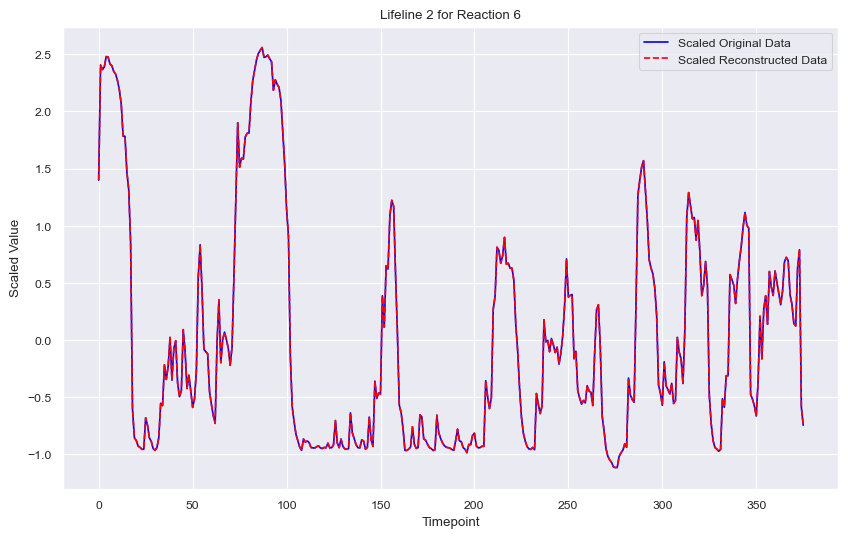

In [70]:
import matplotlib.pyplot as plt

# Choose a specific lifeline and reaction for plotting
lifeline_index = 1  # Index for lifeline 0 (assuming lifelines are zero-indexed)
reaction_index = 6 # Reaction index

# Extract series for plotting
scaled_series = normalized_data[lifeline_index, :, reaction_index]
reconstructed_series = normalized_data[lifeline_index, :, reaction_index]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(scaled_series, label='Scaled Original Data', color='blue')
plt.plot(reconstructed_series, label='Scaled Reconstructed Data', color='red', linestyle='--')
plt.title(f'Lifeline {lifeline_index + 1} for Reaction {reaction_index}')
plt.xlabel('Timepoint')
plt.ylabel('Scaled Value')
plt.legend()
plt.show()

# Training on Multiple Lifelines (100)

In [51]:
import os
import pandas as pd
import numpy as np

folder_path = '100_dFBA_Lifelines'
file_names = sorted(os.listdir(folder_path))

expected_timepoints = 376

for file_name in file_names:
    file_path = os.path.join(folder_path, file_name)
    lifeline_df = pd.read_csv(file_path, sep="\t", index_col=0)

    # Select every 10th row and ensure there are exactly 375 timepoints
    reduced_df = lifeline_df.iloc[::10][:expected_timepoints]
    reduced_df.to_csv(file_path, sep="\t")

data_list_100 = []
filtered_reactions = None

for file_name in file_names:
    file_path = os.path.join(folder_path, file_name)
    lifeline_df = pd.read_csv(file_path, sep="\t", index_col=0)

    if filtered_reactions is None:
        non_constant_fluxes_df = lifeline_df.loc[:, (lifeline_df != lifeline_df.iloc[0]).any()]
        unique_reactions_fluxes_df = non_constant_fluxes_df.loc[:, ~non_constant_fluxes_df.columns.duplicated()]
        filtered_reactions = unique_reactions_fluxes_df.columns

    filtered_lifeline_df = lifeline_df[filtered_reactions]

    if filtered_lifeline_df.shape != (expected_timepoints, len(filtered_reactions)):
        print(f"Shape mismatch for file: {file_name}. Expected ({expected_timepoints}, {len(filtered_reactions)}) but got {filtered_lifeline_df.shape}")

    data_list_100.append(filtered_lifeline_df.to_numpy())

data_3d_100 = np.stack(data_list_100, axis=1)
print("Shape of the Big Matrix:", data_3d_100.shape)


C:\Users\elysi\AppData\Local\Temp\ipykernel_26220\1100832978.py:15: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  reduced_df = lifeline_df.iloc[::10][:expected_timepoints]
C:\Users\elysi\AppData\Local\Temp\ipykernel_26220\1100832978.py:15: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  reduced_df = lifeline_df.iloc[::10][:expected_timepoints]
C:\Users\elysi\AppData\Local\Temp\ipykernel_26220\1100832978.py:15: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  reduced_df = lifeline_df.iloc[::10][:expecte

Shape of the Big Matrix: (376, 101, 48)


In [57]:
from sklearn.preprocessing import StandardScaler
import numpy as np

n_timesteps, n_samples, n_features = data_3d_100.shape

# Initialize a StandardScaler for each feature for each sample
scalers = [[StandardScaler() for _ in range(n_features)] for _ in range(n_samples)]

# Normalized data will have the same shape as data_3d initially
normalized_data_100 = np.empty_like(data_3d_100, dtype=float)

# Apply the scalers to each feature for each sample across all timesteps
for sample_index in range(n_samples):
    for feature_index in range(n_features):
        # Extract the feature data for the current sample
        feature_data = data_3d_100[:, sample_index, feature_index].reshape(-1, 1)
        
        # Fit and transform the data using the corresponding scaler
        normalized_feature_data_100 = scalers[sample_index][feature_index].fit_transform(feature_data)
        
        # Assign the normalized data back to its position in the normalized_data array
        normalized_data_100[:, sample_index, feature_index] = normalized_feature_data_100.flatten()

# Transpose normalized_data to have the shape (n_samples, n_timesteps, n_features)
normalized_data_100 = np.transpose(normalized_data_100, (1, 0, 2))

print("Shape of the Normalized Data:", normalized_data_100.shape)


Shape of the Normalized Data: (101, 376, 48)


In [58]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# If you want to split the 14 sequences into training and validation sets:
num_sequences = normalized_data_100.shape[0]
train_size = int(num_sequences * 0.8)  # 80% for training
val_size = num_sequences - train_size  # 20% for validation

# Split data into training and validation sets
train_data = normalized_data_100[:train_size]
val_data = normalized_data_100[train_size:]

In [59]:
# Define the autoencoder model (same as before, no changes needed)
autoencoder = Sequential([
    LSTM(120, activation='tanh', kernel_initializer='he_uniform', input_shape=(376, 48), return_sequences=False),
    Dense(40, activation='tanh'),
    RepeatVector(376),
    LSTM(120, activation='tanh', return_sequences=True),
    LSTM(48, activation='linear', return_sequences=True)
])

# Learning rate
initial_learning_rate = 0.0001

# Optimizer
optimizer = Adam(learning_rate=initial_learning_rate)

# Compile the model
autoencoder.compile(optimizer=optimizer, loss='mse')

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = autoencoder.fit(
    train_data, train_data,
    epochs=15,
    validation_data=(val_data, val_data),
    callbacks=[reduce_lr, early_stop]
)

# Predict on the validation set
val_predictions = autoencoder.predict(val_data)

# Compute mean squared error on the validation set
mean_squared_error = np.mean(np.square(val_data - val_predictions))

# Compute root mean squared error (RMSE)
reconstruction_loss = np.sqrt(mean_squared_error)
print(f"Validation RMSE: {reconstruction_loss}")


Epoch 1/15
3/3 [==============================] - 8s 1s/step - loss: 1.0103 - val_loss: 1.0079 - lr: 1.0000e-04
Epoch 2/15
3/3 [==============================] - 2s 715ms/step - loss: 1.0064 - val_loss: 1.0054 - lr: 1.0000e-04
Epoch 3/15
3/3 [==============================] - 2s 748ms/step - loss: 1.0039 - val_loss: 1.0038 - lr: 1.0000e-04
Epoch 4/15
3/3 [==============================] - 2s 766ms/step - loss: 1.0024 - val_loss: 1.0027 - lr: 1.0000e-04
Epoch 5/15
3/3 [==============================] - 2s 808ms/step - loss: 1.0013 - val_loss: 1.0020 - lr: 1.0000e-04
Epoch 6/15
3/3 [==============================] - 2s 768ms/step - loss: 1.0006 - val_loss: 1.0014 - lr: 1.0000e-04
Epoch 7/15
3/3 [==============================] - 2s 749ms/step - loss: 1.0000 - val_loss: 1.0009 - lr: 1.0000e-04
Epoch 8/15
3/3 [==============================] - 2s 599ms/step - loss: 0.9996 - val_loss: 1.0005 - lr: 1.0000e-04
Epoch 9/15
3/3 [==============================] - 2s 734ms/step - loss: 0.9992 - va

In [ ]:
# Define a model for extracting latent representations
latent_model = Model(inputs=autoencoder.input, outputs=autoencoder.layers[1].output)

# Extract latent representations using the trained model
latent_reps = latent_model.predict(val_data)

# Convert latent representations to a DataFrame and save to CSV
latent_reps_df = pd.DataFrame(latent_reps)
latent_reps_df.to_csv("latent_representations_100lifelines.csv", index=False)

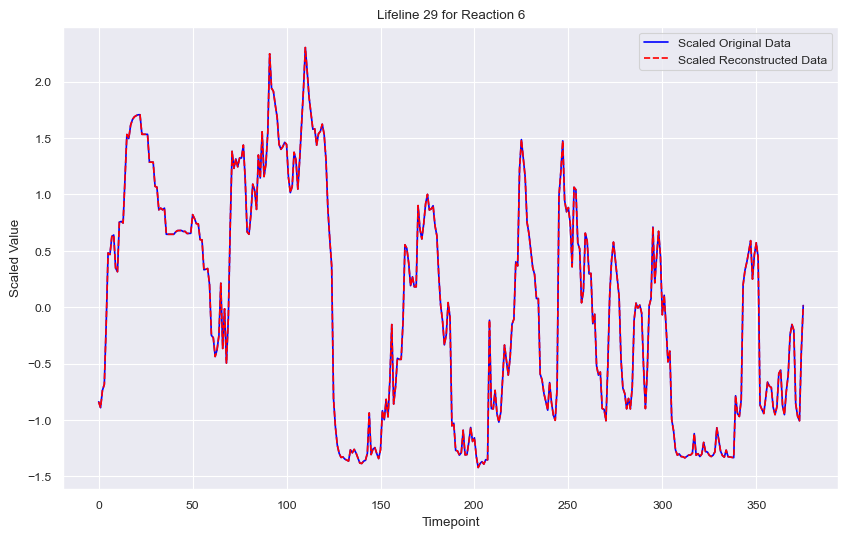

In [61]:
import matplotlib.pyplot as plt

# Choose a specific lifeline and reaction for plotting
lifeline_index = 28  # Index for lifeline 0 (assuming lifelines are zero-indexed)
reaction_index = 6 # Reaction index

# Extract series for plotting
scaled_series = normalized_data[lifeline_index, :, reaction_index]
reconstructed_series = normalized_data[lifeline_index, :, reaction_index]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(scaled_series, label='Scaled Original Data', color='blue')
plt.plot(reconstructed_series, label='Scaled Reconstructed Data', color='red', linestyle='--')
plt.title(f'Lifeline {lifeline_index + 1} for Reaction {reaction_index}')
plt.xlabel('Timepoint')
plt.ylabel('Scaled Value')
plt.legend()
plt.show()

## Training on multiple lifelines (Superseded)

In [4]:
import os
import pandas as pd
import numpy as np

folder_path = 'dFBA_Data_Frames_Lifelines - Small'
file_names = sorted(os.listdir(folder_path))

expected_timepoints = 376

for file_name in file_names:
    file_path = os.path.join(folder_path, file_name)
    lifeline_df = pd.read_csv(file_path, sep="\t", index_col=0)

    # Select every 10th row and ensure there are exactly 375 timepoints
    reduced_df = lifeline_df.iloc[::10][:expected_timepoints]
    reduced_df.to_csv(file_path, sep="\t")

data_list = []
filtered_reactions = None

for file_name in file_names:
    file_path = os.path.join(folder_path, file_name)
    lifeline_df = pd.read_csv(file_path, sep="\t", index_col=0)

    if filtered_reactions is None:
        non_constant_fluxes_df = lifeline_df.loc[:, (lifeline_df != lifeline_df.iloc[0]).any()]
        unique_reactions_fluxes_df = non_constant_fluxes_df.loc[:, ~non_constant_fluxes_df.columns.duplicated()]
        filtered_reactions = unique_reactions_fluxes_df.columns

    filtered_lifeline_df = lifeline_df[filtered_reactions]

    if filtered_lifeline_df.shape != (expected_timepoints, len(filtered_reactions)):
        print(f"Shape mismatch for file: {file_name}. Expected ({expected_timepoints}, {len(filtered_reactions)}) but got {filtered_lifeline_df.shape}")

    data_list.append(filtered_lifeline_df.to_numpy())

data_3d = np.stack(data_list, axis=1)
print("Shape of the Big Matrix:", data_3d.shape)


C:\Users\elysi\AppData\Local\Temp\ipykernel_26220\4099083542.py:15: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  reduced_df = lifeline_df.iloc[::10][:expected_timepoints]
C:\Users\elysi\AppData\Local\Temp\ipykernel_26220\4099083542.py:15: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  reduced_df = lifeline_df.iloc[::10][:expected_timepoints]
C:\Users\elysi\AppData\Local\Temp\ipykernel_26220\4099083542.py:15: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  reduced_df = lifeline_df.iloc[::10][:expecte

Shape of the Big Matrix: (376, 14, 48)


In [6]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# Assuming data_3d is your original data with shape (n_timesteps, n_samples, n_features)
# Example: n_timesteps = 376, n_samples = 14, n_features = 48

n_timesteps, n_samples, n_features = data_3d.shape

# Initialize a StandardScaler for each feature for each sample
scalers = [[StandardScaler() for _ in range(n_features)] for _ in range(n_samples)]

# Normalized data will have the same shape as data_3d initially
normalized_data = np.empty_like(data_3d, dtype=float)

# Apply the scalers to each feature for each sample across all timesteps
for sample_index in range(n_samples):
    for feature_index in range(n_features):
        # Extract the feature data for the current sample
        feature_data = data_3d[:, sample_index, feature_index].reshape(-1, 1)
        
        # Fit and transform the data using the corresponding scaler
        normalized_feature_data = scalers[sample_index][feature_index].fit_transform(feature_data)
        
        # Assign the normalized data back to its position in the normalized_data array
        normalized_data[:, sample_index, feature_index] = normalized_feature_data.flatten()

# Transpose normalized_data to have the shape (n_samples, n_timesteps, n_features)
normalized_data = np.transpose(normalized_data, (1, 0, 2))

print("Shape of the Normalized Data:", normalized_data.shape)


Shape of the Normalized Data: (14, 376, 48)


Test without Hyperparameter Tuning

Model for Training

In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, RepeatVector, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional

class DataGenerator(Sequence):
    def __init__(self, data, batch_size=1, shuffle=True):
        # data shape should be (14, 376, 48) before passing into this generator
        self.data = data
        self.batch_size = batch_size  # Intending to treat each lifeline as a batch
        self.shuffle = shuffle
        self.indices = np.arange(data.shape[0])  # Number of lifelines
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __len__(self):
        # Compute how many batches are in the dataset
        return int(np.ceil(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        # Compute start and end indices for batch
        start_idx = index * self.batch_size
        end_idx = min((index + 1) * self.batch_size, len(self.data))
        
        # Selecting the batch (handling the case where the last batch may be smaller)
        batch_data = self.data[start_idx:end_idx]  # Shape should be (batch_size, 376, 48)
        
        # Ensure batch_data is reshaped correctly if batch_size = 1 to avoid shape mismatch
        if batch_data.shape[0] == 1:
            batch_data = batch_data.reshape(batch_data.shape[1:])  # Reshape to (376, 48)
            batch_data = np.expand_dims(batch_data, axis=0)  # Add batch dimension back
        
        return batch_data, batch_data  # X and Y are the same for autoencoder

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)


# Define the autoencoder model using Sequential
autoencoder = Sequential()

# Encoder
autoencoder.add(LSTM(120, activation='tanh', kernel_initializer='he_uniform', input_shape=(376, 48), return_sequences=False))
autoencoder.add(Dense(40, activation='tanh'))  # This layer acts as the latent representation

# Decoder
autoencoder.add(RepeatVector(376))
autoencoder.add(LSTM(120, activation='tanh', return_sequences=True))
autoencoder.add(LSTM(48, activation='linear', return_sequences=True))  # Reconstructing the original input

# Learning rate
initial_learning_rate = 0.0001

# Optimizer
optimizer = Adam(learning_rate=initial_learning_rate)

# Compile the model
autoencoder.compile(optimizer=optimizer, loss='mse')

# Summary of the model
autoencoder.summary()




Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 120)               81120     
                                                                 
 dense_1 (Dense)             (None, 40)                4840      
                                                                 
 repeat_vector_1 (RepeatVec  (None, 376, 40)           0         
 tor)                                                            
                                                                 
 lstm_4 (LSTM)               (None, 376, 120)          77280     
                                                                 
 lstm_5 (LSTM)               (None, 376, 48)           32448     
                                                                 
Total params: 195688 (764.41 KB)
Trainable params: 195688 (764.41 KB)
Non-trainable params: 0 (0.00 Byte)
______________

Separate Model for Latent Representations   

In [8]:
import pandas as pd
from tensorflow.keras.models import Model

# Now, you'll create a new Sequential model for the encoder part
encoder_model = Sequential()

# Add encoder layers from the autoencoder model
for layer in autoencoder.layers[:2]:  # Assuming the first 2 layers are the encoder part
    encoder_model.add(layer)

# Now, `encoder_model` is effectively the encoder part of your autoencoder
# You can use it to predict latent representations
latent_reps = encoder_model.predict(normalized_data)

# Convert latent representations to a DataFrame
latent_reps_df = pd.DataFrame(latent_reps)

# Save to CSV
latent_reps_df.to_csv("latent_representations_test3.csv", index=False)


1/1 [==============================] - 1s 574ms/step


In [9]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, RepeatVector, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split

# The second dimension, 14, represents the samples (lifelines)
# Split indices of the samples into training and validation sets
train_indices, val_indices = train_test_split(np.arange(normalized_data.shape[0]), test_size=0.2, random_state=42)
# train_indices, val_indices = train_test_split(np.arange(data_3d.shape[0]), test_size=0.2, random_state=42)

# Extract the corresponding data for training and validation
# Keep all timesteps (first dimension) and features (third dimension) intact
train_data = normalized_data[train_indices, :, :]
val_data = normalized_data[val_indices, :, :]

# Now train_data and val_data should have shapes like (376, num_train_samples, 48) and (376, num_val_samples, 48) respectively
print("Train data shape:", train_data.shape)

# Create the generators with the correct batch size
train_gen = DataGenerator(train_data, batch_size=1, shuffle=True)
val_gen = DataGenerator(val_data, batch_size=1, shuffle=False)  # No need to shuffle validation data

Train data shape: (11, 376, 48)


In [10]:
# Show batch_data in train_gen
batch_data = train_gen.__getitem__(0)
print("Batch data shape:", batch_data[1].shape)
batch_data[1]

Batch data shape: (1, 376, 48)


array([[[-0.38074335, -0.38074335, -0.23516267, ..., -0.77328201,
         -0.62303298, -0.89066641],
        [-0.02424562, -0.02424562,  0.0721159 , ..., -0.81454603,
         -0.21889434, -0.89066641],
        [ 0.09841322,  0.09841322,  0.17784009, ..., -0.82874359,
         -0.07984385, -0.89066641],
        ...,
        [-0.79457243, -0.79457243, -0.87213736, ...,  1.34913317,
         -0.60635193,  1.36992633],
        [-0.7887739 , -0.7887739 , -0.86143133, ...,  1.30621334,
         -0.60967235,  1.32388809],
        [-0.79529043, -0.79529043, -0.87346302, ...,  1.35444768,
         -0.60594078,  1.37562697]]])

In [12]:
normalized_data.shape

(14, 376, 48)

In [17]:
# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fit the autoencoder using the generators
history = autoencoder.fit(train_gen, validation_data=val_gen, epochs=15, callbacks=[reduce_lr, early_stop])

# Predict on the entire validation set
val_predictions = autoencoder.predict(val_gen)

# Compute mean squared error on the validation set
mean_squared_error = np.mean(np.square(val_data - val_predictions))

# Compute root mean squared error (RMSE)
reconstruction_loss = np.sqrt(mean_squared_error)
print(f"Validation RMSE: {reconstruction_loss}")


Epoch 1/15
11/11 [==============================] - 4s 331ms/step - loss: 0.9963 - val_loss: 0.9941 - lr: 1.0000e-04
Epoch 2/15
11/11 [==============================] - 3s 302ms/step - loss: 0.9962 - val_loss: 0.9942 - lr: 1.0000e-04
Epoch 3/15
11/11 [==============================] - 3s 311ms/step - loss: 0.9961 - val_loss: 0.9943 - lr: 1.0000e-04
Epoch 4/15
11/11 [==============================] - 3s 317ms/step - loss: 0.9961 - val_loss: 0.9944 - lr: 1.0000e-04
Epoch 5/15
11/11 [==============================] - 3s 320ms/step - loss: 0.9960 - val_loss: 0.9943 - lr: 1.0000e-04
Epoch 6/15
11/11 [==============================] - 4s 330ms/step - loss: 0.9960 - val_loss: 0.9944 - lr: 1.0000e-04
Epoch 7/15
11/11 [==============================] - 4s 318ms/step - loss: 0.9959 - val_loss: 0.9944 - lr: 5.0000e-05
Epoch 8/15
11/11 [==============================] - 4s 333ms/step - loss: 0.9959 - val_loss: 0.9944 - lr: 5.0000e-05
Epoch 9/15
11/11 [==============================] - 4s 326ms/ste

In [14]:
#autoencoder.fit(scaled_data, scaled_data, epochs=100, batch_size=3, validation_split=0.2, callbacks=[reduce_lr, early_stop])
#reconstructed_data = autoencoder.predict(scaled_data)

#autoencoder.fit(scaled_data, scaled_data, epochs=100, batch_size=3, validation_split=0.2, callbacks=[reduce_lr, early_stop])
reconstructed_data = autoencoder.predict(normalized_data)

1/1 [==============================] - 1s 945ms/step


In [27]:
# fit model
autoencoder.fit(scaled_data, scaled_data, epochs=15, batch_size=2, verbose=0)
# demonstrate reconstruction
yhat = autoencoder.predict(scaled_data, verbose=0)
print('---Predicted---')
print(np.round(yhat,3))
print('---Actual---')
print(np.round(scaled_data, 3))

---Predicted---
[[[0.121 0.041 0.053 ... 0.16  0.024 0.117]
  [0.203 0.08  0.1   ... 0.283 0.061 0.207]
  [0.262 0.121 0.136 ... 0.377 0.105 0.275]
  ...
  [0.262 0.207 0.205 ... 0.522 0.192 0.39 ]
  [0.261 0.207 0.205 ... 0.523 0.192 0.39 ]
  [0.261 0.207 0.205 ... 0.523 0.191 0.39 ]]

 [[0.104 0.038 0.051 ... 0.135 0.017 0.115]
  [0.177 0.074 0.092 ... 0.238 0.05  0.2  ]
  [0.229 0.109 0.123 ... 0.317 0.091 0.262]
  ...
  [0.213 0.205 0.215 ... 0.421 0.199 0.346]
  [0.213 0.205 0.215 ... 0.421 0.198 0.346]
  [0.212 0.205 0.215 ... 0.421 0.198 0.345]]

 [[0.098 0.041 0.049 ... 0.126 0.018 0.112]
  [0.167 0.078 0.088 ... 0.222 0.049 0.196]
  [0.213 0.113 0.117 ... 0.296 0.088 0.257]
  ...
  [0.191 0.203 0.204 ... 0.391 0.193 0.335]
  [0.191 0.203 0.204 ... 0.391 0.193 0.335]
  [0.191 0.203 0.204 ... 0.391 0.193 0.334]]

 ...

 [[0.113 0.04  0.057 ... 0.147 0.021 0.125]
  [0.192 0.078 0.101 ... 0.259 0.058 0.218]
  [0.247 0.115 0.134 ... 0.345 0.102 0.286]
  ...
  [0.223 0.21  0.224 ...

In [28]:
print('---Actual---')
print(np.round(scaled_data, 3))

---Actual---
[[[0.103 0.103 0.12  ... 0.159 0.021 0.   ]
  [0.241 0.241 0.209 ... 0.134 0.172 0.   ]
  [0.184 0.184 0.173 ... 0.144 0.111 0.   ]
  ...
  [0.002 0.002 0.002 ... 0.98  0.03  0.976]
  [0.    0.    0.    ... 0.997 0.031 0.996]
  [0.043 0.043 0.059 ... 0.516 0.007 0.421]]

 [[0.248 0.248 0.255 ... 0.25  0.22  0.   ]
  [0.784 0.784 0.737 ... 0.072 0.776 0.   ]
  [0.963 0.963 0.898 ... 0.012 0.962 0.   ]
  ...
  [0.417 0.417 0.407 ... 0.194 0.396 0.   ]
  [0.469 0.469 0.454 ... 0.176 0.45  0.   ]
  [0.356 0.356 0.353 ... 0.214 0.333 0.   ]]

 [[0.161 0.161 0.182 ... 0.148 0.091 0.   ]
  [0.    0.    0.    ... 1.    0.038 1.   ]
  [0.053 0.053 0.084 ... 0.401 0.009 0.285]
  ...
  [0.078 0.078 0.12  ... 0.162 0.001 0.   ]
  [0.353 0.353 0.323 ... 0.114 0.299 0.   ]
  [0.07  0.07  0.111 ... 0.213 0.    0.06 ]]

 ...

 [[0.637 0.637 0.531 ... 0.061 0.604 0.   ]
  [1.    1.    1.    ... 0.    1.    0.   ]
  [0.489 0.489 0.423 ... 0.086 0.443 0.   ]
  ...
  [0.617 0.617 0.517 ... 0.

In [15]:
reconstructed_data.shape

(14, 376, 48)

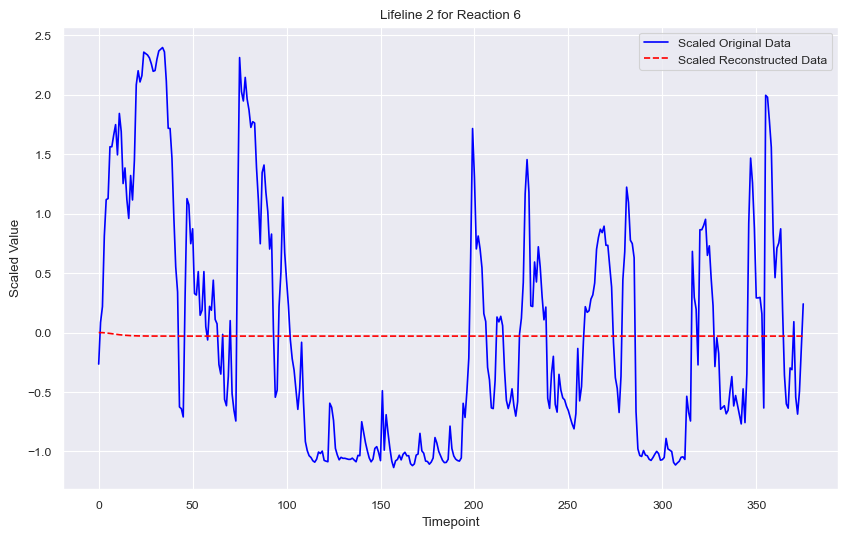

In [16]:
import matplotlib.pyplot as plt

# Choose a specific lifeline and reaction for plotting
lifeline_index = 1  # Index for lifeline 2 (assuming lifelines are zero-indexed)
reaction_index = 6 # Reaction index

# Extract series for plotting
scaled_series = normalized_data[lifeline_index, :, reaction_index]
reconstructed_series = reconstructed_data[lifeline_index, :, reaction_index]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(scaled_series, label='Scaled Original Data', color='blue')
plt.plot(reconstructed_series, label='Scaled Reconstructed Data', color='red', linestyle='--')
plt.title(f'Lifeline {lifeline_index + 1} for Reaction {reaction_index}')
plt.xlabel('Timepoint')
plt.ylabel('Scaled Value')
plt.legend()
plt.show()

# Multiple Lifelines Testing with Hyperparameter Tuning

In [22]:
import numpy as np
import optuna
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, RepeatVector, Dense
from tensorflow.keras.models import Model
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.utils import Sequence
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

class DataGenerator(Sequence):
    def __init__(self, data, batch_size=1, shuffle=True):
        # data shape should be (14, 376, 48) before passing into this generator
        self.data = data
        self.batch_size = batch_size  # Intending to treat each lifeline as a batch
        self.shuffle = shuffle
        self.indices = np.arange(data.shape[0])  # Number of lifelines
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __len__(self):
        # Compute how many batches are in the dataset
        return int(np.ceil(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        # Compute start and end indices for batch
        start_idx = index * self.batch_size
        end_idx = min((index + 1) * self.batch_size, len(self.data))
        
        # Selecting the batch (handling the case where the last batch may be smaller)
        batch_data = self.data[start_idx:end_idx]  # Shape should be (batch_size, 376, 48)
        
        # Ensure batch_data is reshaped correctly if batch_size = 1 to avoid shape mismatch
        if batch_data.shape[0] == 1:
            batch_data = batch_data.reshape(batch_data.shape[1:])  # Reshape to (376, 48)
            batch_data = np.expand_dims(batch_data, axis=0)  # Add batch dimension back
        
        return batch_data, batch_data  # X and Y are the same for autoencoder

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)


def create_autoencoder(input_shape, hidden_units, latent_units, learning_rate):
    autoencoder = Sequential()
    # Encoder
    autoencoder.add(LSTM(hidden_units, activation='tanh', input_shape=input_shape, return_sequences=False))
    autoencoder.add(Dense(latent_units, activation='tanh'))
    # Decoder
    autoencoder.add(RepeatVector(input_shape[0]))
    autoencoder.add(LSTM(hidden_units, activation='tanh', return_sequences=True))
    autoencoder.add(LSTM(input_shape[1], activation='linear', return_sequences=True))
    # Compile model
    optimizer = Adam(learning_rate=learning_rate)
    autoencoder.compile(optimizer=optimizer, loss='mse')
    return autoencoder

def objective(trial):
    # Hyperparameters to tune
    hidden_units = trial.suggest_int('hidden_units', 50, 150)
    latent_units = trial.suggest_int('latent_units', 20, 70)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
    batch_size = trial.suggest_categorical('batch_size', [1, 2, 4])
    
    # Create the autoencoder model
    autoencoder = create_autoencoder((376, 48), hidden_units, latent_units, learning_rate)
    
    # Split the data into training and validation sets
    train_indices, val_indices = train_test_split(np.arange(normalized_data.shape[0]), test_size=0.2, random_state=42)
    train_data = normalized_data[train_indices, :, :]
    val_data = normalized_data[val_indices, :, :]
    
    # Create data generators
    train_gen = DataGenerator(train_data, batch_size=batch_size, shuffle=True)
    val_gen = DataGenerator(val_data, batch_size=batch_size, shuffle=False)
    
    # Callbacks for early stopping and learning rate reduction
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Fit the model
    history = autoencoder.fit(train_gen, validation_data=val_gen, epochs=15, callbacks=[reduce_lr, early_stop])
    
    # Use the last recorded validation loss as the metric to minimize
    val_loss = history.history['val_loss'][-1]
    return val_loss

# Initialize Optuna study and optimize
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)  # Modify `n_trials` to the desired number of trials

# Print the best hyperparameters
print('Best trial:', study.best_trial.params)


c:\Users\elysi\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-02-06 02:25:55,682] A new study created in memory with name: no-name-ea13988d-b3da-4108-9c08-8a1c94963686
C:\Users\elysi\AppData\Local\Temp\ipykernel_17796\4094919889.py:63: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Epoch 1/15
11/11 [==============================] - 9s 372ms/step - loss: 1.0150 - val_loss: 1.0064 - lr: 0.0029
Epoch 2/15
11/11 [==============================] - 3s 286ms/step - loss: 1.0023 - val_loss: 1.0051 - lr: 0.0029
Epoch 3/15
11/11 [==============================] - 3s 287ms/step - loss: 1.0001 - val_loss: 0.9962 - lr: 0.0029
Epoch 4/15
11/11 [==============================] - 3s 296ms/step - loss: 0.9977 - val_loss: 0.9949 - lr: 0.0029
Epoch 5/15
11/11 [==============================] - 3s 296ms/step - loss: 0.9964 - val_loss: 0.9939 - lr: 0.0029
Epoch 6/15
11/11 [==============================] - 3s 299ms/step - loss: 0.9961 - val_loss: 0.9939 - lr: 0.0029
Epoch 7/15
11/11 [==============================] - 3s 296ms/step - loss: 0.9960 - val_loss: 0.9939 - lr: 0.0029
Epoch 8/15
11/11 [==============================] - 3s 295ms/step - loss: 0.9958 - val_loss: 0.9942 - lr: 0.0029
Epoch 9/15
11/11 [==============================] - 3s 295ms/step - loss: 0.9956 - val_loss: 0.9

[I 2024-02-06 02:26:50,043] Trial 0 finished with value: 0.9993252754211426 and parameters: {'hidden_units': 104, 'latent_units': 69, 'learning_rate': 0.0029287494558908633, 'batch_size': 1}. Best is trial 0 with value: 0.9993252754211426.


Epoch 1/15
3/3 [==============================] - 6s 890ms/step - loss: 1.0037 - val_loss: 0.9964 - lr: 3.9527e-04
Epoch 2/15
3/3 [==============================] - 1s 487ms/step - loss: 0.9985 - val_loss: 0.9954 - lr: 3.9527e-04
Epoch 3/15
3/3 [==============================] - 1s 513ms/step - loss: 0.9976 - val_loss: 0.9952 - lr: 3.9527e-04
Epoch 4/15
3/3 [==============================] - 1s 494ms/step - loss: 0.9971 - val_loss: 0.9947 - lr: 3.9527e-04
Epoch 5/15
3/3 [==============================] - 2s 501ms/step - loss: 0.9968 - val_loss: 0.9944 - lr: 3.9527e-04
Epoch 6/15
3/3 [==============================] - 2s 505ms/step - loss: 0.9967 - val_loss: 0.9943 - lr: 3.9527e-04
Epoch 7/15
3/3 [==============================] - 2s 551ms/step - loss: 0.9965 - val_loss: 0.9943 - lr: 3.9527e-04
Epoch 8/15
3/3 [==============================] - 2s 536ms/step - loss: 0.9964 - val_loss: 0.9944 - lr: 3.9527e-04
Epoch 9/15
3/3 [==============================] - 2s 529ms/step - loss: 0.9963 -

[I 2024-02-06 02:27:17,985] Trial 1 finished with value: 0.9940786957740784 and parameters: {'hidden_units': 144, 'latent_units': 67, 'learning_rate': 0.0003952743821899014, 'batch_size': 4}. Best is trial 1 with value: 0.9940786957740784.


Epoch 1/15
11/11 [==============================] - 8s 341ms/step - loss: 1.0003 - val_loss: 0.9967 - lr: 2.1330e-04
Epoch 2/15
11/11 [==============================] - 3s 264ms/step - loss: 0.9976 - val_loss: 0.9952 - lr: 2.1330e-04
Epoch 3/15
11/11 [==============================] - 3s 282ms/step - loss: 0.9969 - val_loss: 0.9948 - lr: 2.1330e-04
Epoch 4/15
11/11 [==============================] - 3s 280ms/step - loss: 0.9966 - val_loss: 0.9950 - lr: 2.1330e-04
Epoch 5/15
11/11 [==============================] - 3s 287ms/step - loss: 0.9964 - val_loss: 0.9947 - lr: 2.1330e-04
Epoch 6/15
11/11 [==============================] - 3s 271ms/step - loss: 0.9964 - val_loss: 0.9945 - lr: 2.1330e-04
Epoch 7/15
11/11 [==============================] - 3s 280ms/step - loss: 0.9963 - val_loss: 0.9946 - lr: 2.1330e-04
Epoch 8/15
11/11 [==============================] - 3s 276ms/step - loss: 0.9962 - val_loss: 0.9946 - lr: 2.1330e-04
Epoch 9/15
11/11 [==============================] - 3s 238ms/ste

[I 2024-02-06 02:28:07,921] Trial 2 finished with value: 0.9950361251831055 and parameters: {'hidden_units': 104, 'latent_units': 21, 'learning_rate': 0.00021329691047223688, 'batch_size': 1}. Best is trial 1 with value: 0.9940786957740784.


Epoch 1/15
3/3 [==============================] - 6s 914ms/step - loss: 1.0025 - val_loss: 0.9983 - lr: 0.0036
Epoch 2/15
3/3 [==============================] - 2s 523ms/step - loss: 1.0008 - val_loss: 0.9980 - lr: 0.0036
Epoch 3/15
3/3 [==============================] - 2s 518ms/step - loss: 0.9994 - val_loss: 1.0008 - lr: 0.0036
Epoch 4/15
3/3 [==============================] - 2s 532ms/step - loss: 0.9996 - val_loss: 0.9954 - lr: 0.0036
Epoch 5/15
3/3 [==============================] - 2s 611ms/step - loss: 0.9970 - val_loss: 0.9951 - lr: 0.0036
Epoch 6/15
3/3 [==============================] - 2s 622ms/step - loss: 0.9966 - val_loss: 0.9946 - lr: 0.0036
Epoch 7/15
3/3 [==============================] - 2s 513ms/step - loss: 0.9964 - val_loss: 0.9947 - lr: 0.0036
Epoch 8/15
3/3 [==============================] - 2s 581ms/step - loss: 0.9962 - val_loss: 0.9949 - lr: 0.0036
Epoch 9/15
3/3 [==============================] - 2s 546ms/step - loss: 0.9960 - val_loss: 0.9949 - lr: 0.0036
E

[I 2024-02-06 02:28:37,472] Trial 3 finished with value: 1.002213716506958 and parameters: {'hidden_units': 147, 'latent_units': 20, 'learning_rate': 0.003636747458758834, 'batch_size': 4}. Best is trial 1 with value: 0.9940786957740784.


Epoch 1/15
3/3 [==============================] - 6s 781ms/step - loss: 1.0116 - val_loss: 1.0065 - lr: 0.0087
Epoch 2/15
3/3 [==============================] - 1s 390ms/step - loss: 1.0038 - val_loss: 1.0003 - lr: 0.0087
Epoch 3/15
3/3 [==============================] - 1s 393ms/step - loss: 0.9991 - val_loss: 0.9956 - lr: 0.0087
Epoch 4/15
3/3 [==============================] - 1s 389ms/step - loss: 0.9972 - val_loss: 0.9943 - lr: 0.0087
Epoch 5/15
3/3 [==============================] - 1s 386ms/step - loss: 0.9966 - val_loss: 0.9939 - lr: 0.0087
Epoch 6/15
3/3 [==============================] - 1s 401ms/step - loss: 0.9965 - val_loss: 0.9935 - lr: 0.0087
Epoch 7/15
3/3 [==============================] - 1s 390ms/step - loss: 0.9963 - val_loss: 0.9934 - lr: 0.0087
Epoch 8/15
3/3 [==============================] - 1s 368ms/step - loss: 0.9962 - val_loss: 0.9934 - lr: 0.0087
Epoch 9/15
3/3 [==============================] - 1s 427ms/step - loss: 0.9962 - val_loss: 0.9934 - lr: 0.0087
E

[I 2024-02-06 02:29:00,106] Trial 4 finished with value: 0.9938101172447205 and parameters: {'hidden_units': 72, 'latent_units': 47, 'learning_rate': 0.00871620405013944, 'batch_size': 4}. Best is trial 4 with value: 0.9938101172447205.


Epoch 1/15
3/3 [==============================] - 6s 781ms/step - loss: 1.0046 - val_loss: 1.0001 - lr: 3.0704e-04
Epoch 2/15
3/3 [==============================] - 1s 470ms/step - loss: 1.0002 - val_loss: 0.9989 - lr: 3.0704e-04
Epoch 3/15
3/3 [==============================] - 1s 423ms/step - loss: 0.9989 - val_loss: 0.9979 - lr: 3.0704e-04
Epoch 4/15
3/3 [==============================] - 1s 405ms/step - loss: 0.9981 - val_loss: 0.9967 - lr: 3.0704e-04
Epoch 5/15
3/3 [==============================] - 1s 410ms/step - loss: 0.9976 - val_loss: 0.9962 - lr: 3.0704e-04
Epoch 6/15
3/3 [==============================] - 1s 436ms/step - loss: 0.9973 - val_loss: 0.9962 - lr: 3.0704e-04
Epoch 7/15
3/3 [==============================] - 1s 407ms/step - loss: 0.9970 - val_loss: 0.9962 - lr: 3.0704e-04
Epoch 8/15
3/3 [==============================] - 1s 410ms/step - loss: 0.9968 - val_loss: 0.9962 - lr: 3.0704e-04
Epoch 9/15
3/3 [==============================] - 1s 477ms/step - loss: 0.9967 -

[I 2024-02-06 02:29:24,548] Trial 5 finished with value: 0.9955602288246155 and parameters: {'hidden_units': 81, 'latent_units': 48, 'learning_rate': 0.0003070383582309366, 'batch_size': 4}. Best is trial 4 with value: 0.9938101172447205.


Epoch 1/15
3/3 [==============================] - 6s 751ms/step - loss: 1.0019 - val_loss: 0.9999 - lr: 0.0072
Epoch 2/15
3/3 [==============================] - 1s 377ms/step - loss: 0.9996 - val_loss: 0.9971 - lr: 0.0072
Epoch 3/15
3/3 [==============================] - 1s 407ms/step - loss: 0.9977 - val_loss: 0.9956 - lr: 0.0072
Epoch 4/15
3/3 [==============================] - 1s 336ms/step - loss: 0.9970 - val_loss: 0.9950 - lr: 0.0072
Epoch 5/15
3/3 [==============================] - 1s 404ms/step - loss: 0.9968 - val_loss: 0.9945 - lr: 0.0072
Epoch 6/15
3/3 [==============================] - 1s 395ms/step - loss: 0.9965 - val_loss: 0.9939 - lr: 0.0072
Epoch 7/15
3/3 [==============================] - 1s 377ms/step - loss: 0.9963 - val_loss: 0.9939 - lr: 0.0072
Epoch 8/15
3/3 [==============================] - 1s 390ms/step - loss: 0.9962 - val_loss: 0.9938 - lr: 0.0072
Epoch 9/15
3/3 [==============================] - 1s 374ms/step - loss: 0.9962 - val_loss: 0.9937 - lr: 0.0072
E

[I 2024-02-06 02:29:46,928] Trial 6 finished with value: 0.9941309094429016 and parameters: {'hidden_units': 67, 'latent_units': 20, 'learning_rate': 0.007225565019032123, 'batch_size': 4}. Best is trial 4 with value: 0.9938101172447205.


Epoch 1/15
6/6 [==============================] - 8s 576ms/step - loss: 1.0044 - val_loss: 1.0010 - lr: 0.0018
Epoch 2/15
6/6 [==============================] - 3s 439ms/step - loss: 1.0021 - val_loss: 0.9984 - lr: 0.0018
Epoch 3/15
6/6 [==============================] - 3s 472ms/step - loss: 0.9996 - val_loss: 0.9976 - lr: 0.0018
Epoch 4/15
6/6 [==============================] - 3s 429ms/step - loss: 0.9981 - val_loss: 0.9950 - lr: 0.0018
Epoch 5/15
6/6 [==============================] - 3s 428ms/step - loss: 0.9971 - val_loss: 0.9946 - lr: 0.0018
Epoch 6/15
6/6 [==============================] - 3s 413ms/step - loss: 0.9966 - val_loss: 0.9948 - lr: 0.0018
Epoch 7/15
6/6 [==============================] - 3s 430ms/step - loss: 0.9965 - val_loss: 0.9944 - lr: 0.0018
Epoch 8/15
6/6 [==============================] - 3s 438ms/step - loss: 0.9963 - val_loss: 0.9942 - lr: 0.0018
Epoch 9/15
6/6 [==============================] - 3s 423ms/step - loss: 0.9962 - val_loss: 0.9942 - lr: 0.0018
E

[I 2024-02-06 02:30:32,199] Trial 7 finished with value: 0.9954833984375 and parameters: {'hidden_units': 121, 'latent_units': 47, 'learning_rate': 0.0017773097195224036, 'batch_size': 2}. Best is trial 4 with value: 0.9938101172447205.


Epoch 1/15
6/6 [==============================] - 9s 610ms/step - loss: 1.0018 - val_loss: 0.9961 - lr: 3.7151e-04
Epoch 2/15
6/6 [==============================] - 4s 612ms/step - loss: 0.9984 - val_loss: 0.9951 - lr: 3.7151e-04
Epoch 3/15
6/6 [==============================] - 3s 506ms/step - loss: 0.9975 - val_loss: 0.9948 - lr: 3.7151e-04
Epoch 4/15
6/6 [==============================] - 4s 608ms/step - loss: 0.9970 - val_loss: 0.9947 - lr: 3.7151e-04
Epoch 5/15
6/6 [==============================] - 3s 560ms/step - loss: 0.9967 - val_loss: 0.9947 - lr: 3.7151e-04
Epoch 6/15
6/6 [==============================] - 4s 637ms/step - loss: 0.9966 - val_loss: 0.9946 - lr: 3.7151e-04
Epoch 7/15
6/6 [==============================] - 4s 612ms/step - loss: 0.9965 - val_loss: 0.9944 - lr: 3.7151e-04
Epoch 8/15
6/6 [==============================] - 4s 631ms/step - loss: 0.9964 - val_loss: 0.9944 - lr: 3.7151e-04
Epoch 9/15
6/6 [==============================] - 3s 545ms/step - loss: 0.9964 -

[I 2024-02-06 02:31:25,940] Trial 8 finished with value: 0.9943656921386719 and parameters: {'hidden_units': 58, 'latent_units': 27, 'learning_rate': 0.00037151151714706236, 'batch_size': 2}. Best is trial 4 with value: 0.9938101172447205.


Epoch 1/15
6/6 [==============================] - 7s 559ms/step - loss: 1.0018 - val_loss: 0.9961 - lr: 7.0038e-04
Epoch 2/15
6/6 [==============================] - 2s 315ms/step - loss: 0.9988 - val_loss: 0.9955 - lr: 7.0038e-04
Epoch 3/15
6/6 [==============================] - 2s 364ms/step - loss: 0.9973 - val_loss: 0.9949 - lr: 7.0038e-04
Epoch 4/15
6/6 [==============================] - 2s 347ms/step - loss: 0.9967 - val_loss: 0.9947 - lr: 7.0038e-04
Epoch 5/15
6/6 [==============================] - 2s 354ms/step - loss: 0.9964 - val_loss: 0.9946 - lr: 7.0038e-04
Epoch 6/15
6/6 [==============================] - 2s 343ms/step - loss: 0.9962 - val_loss: 0.9950 - lr: 7.0038e-04
Epoch 7/15
6/6 [==============================] - 2s 383ms/step - loss: 0.9962 - val_loss: 0.9949 - lr: 7.0038e-04
Epoch 8/15
6/6 [==============================] - 2s 368ms/step - loss: 0.9961 - val_loss: 0.9944 - lr: 7.0038e-04
Epoch 9/15
6/6 [==============================] - 2s 367ms/step - loss: 0.9959 -

[I 2024-02-06 02:32:03,988] Trial 9 finished with value: 1.0428285598754883 and parameters: {'hidden_units': 83, 'latent_units': 52, 'learning_rate': 0.0007003830137363347, 'batch_size': 2}. Best is trial 4 with value: 0.9938101172447205.


Best trial: {'hidden_units': 72, 'latent_units': 47, 'learning_rate': 0.00871620405013944, 'batch_size': 4}


In [23]:
best_params = study.best_params
best_loss = study.best_value
print("Best Hyperparameters:", best_params)
print("Best Loss:", best_loss)

Best Hyperparameters: {'hidden_units': 72, 'latent_units': 47, 'learning_rate': 0.00871620405013944, 'batch_size': 4}
Best Loss: 0.9938101172447205


In [24]:
# Assuming you have already run the Optuna optimization and have the best hyperparameters
best_params = study.best_params
best_loss = study.best_value

print("Best Hyperparameters:", best_params)
print("Best Loss:", best_loss)

# Create the autoencoder model with the best hyperparameters
best_autoencoder = create_autoencoder(
    input_shape=(376, 48),  # Assuming this is the fixed shape of your input data
    hidden_units=best_params['hidden_units'],
    latent_units=best_params['latent_units'],
    learning_rate=best_params['learning_rate']
)

# Split the data into training and validation sets
# This assumes `normalized_data` is your dataset already loaded and preprocessed
train_indices, val_indices = train_test_split(np.arange(normalized_data.shape[0]), test_size=0.2, random_state=42)
train_data = normalized_data[train_indices, :, :]
val_data = normalized_data[val_indices, :, :]

# Create data generators with the best batch size
train_gen = DataGenerator(train_data, batch_size=best_params['batch_size'], shuffle=True)
val_gen = DataGenerator(val_data, batch_size=best_params['batch_size'], shuffle=False)

# Callbacks for early stopping and learning rate reduction
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fit the model with the best hyperparameters
history = best_autoencoder.fit(train_gen, validation_data=val_gen, epochs=15, callbacks=[reduce_lr, early_stop])

# After training, you can evaluate the model on your validation set or use it for predictions as needed
val_predictions = best_autoencoder.predict(val_gen)
mean_squared_error = np.mean(np.square(val_data - val_predictions))
reconstruction_loss = np.sqrt(mean_squared_error)
print(f"Validation RMSE with Best Hyperparameters: {reconstruction_loss}")


Best Hyperparameters: {'hidden_units': 72, 'latent_units': 47, 'learning_rate': 0.00871620405013944, 'batch_size': 4}
Best Loss: 0.9938101172447205
Epoch 1/15
3/3 [==============================] - 7s 833ms/step - loss: 1.0113 - val_loss: 1.0108 - lr: 0.0087
Epoch 2/15
3/3 [==============================] - 1s 402ms/step - loss: 1.0094 - val_loss: 1.0030 - lr: 0.0087
Epoch 3/15
3/3 [==============================] - 1s 370ms/step - loss: 1.0007 - val_loss: 0.9976 - lr: 0.0087
Epoch 4/15
3/3 [==============================] - 1s 390ms/step - loss: 0.9973 - val_loss: 0.9948 - lr: 0.0087
Epoch 5/15
3/3 [==============================] - 1s 453ms/step - loss: 0.9970 - val_loss: 0.9938 - lr: 0.0087
Epoch 6/15
3/3 [==============================] - 1s 425ms/step - loss: 0.9965 - val_loss: 0.9935 - lr: 0.0087
Epoch 7/15
3/3 [==============================] - 1s 410ms/step - loss: 0.9964 - val_loss: 0.9934 - lr: 0.0087
Epoch 8/15
3/3 [==============================] - 1s 423ms/step - loss: 0.9

1/1 [==============================] - 0s 170ms/step


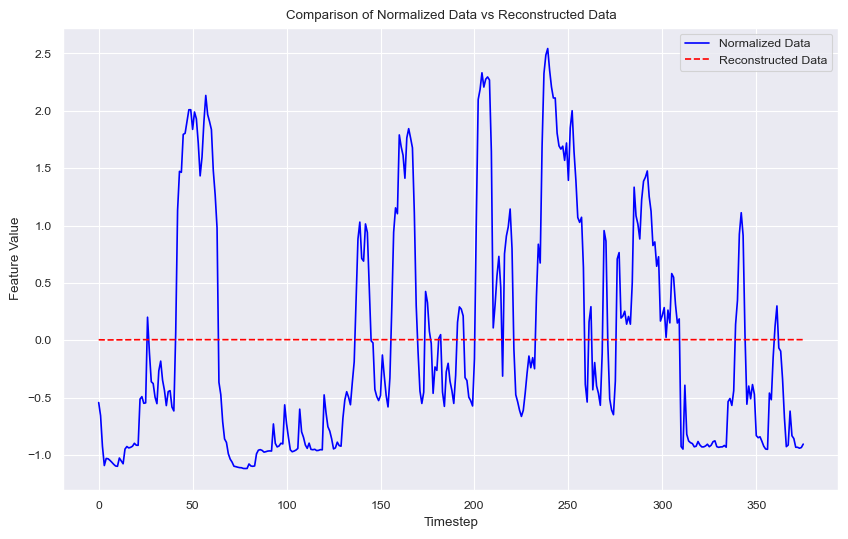

In [27]:
import matplotlib.pyplot as plt

# Predict the reconstructed data using the autoencoder
reconstructed_data = best_autoencoder.predict(normalized_data)

# Extract the specific lifeline (e.g., lifeline 2) and feature (e.g., feature 6) from normalized data
# Adjusting indices for Python's zero-based indexing: lifeline 2 -> index 1, feature 6 -> index 5
normalized_feature_values = normalized_data[2, :, 6]

# Extract the same for the reconstructed data
reconstructed_feature_values = reconstructed_data[2, :, 6]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(normalized_feature_values, label='Normalized Data', color='blue')
plt.plot(reconstructed_feature_values, label='Reconstructed Data', color='red', linestyle='--')
plt.title('Comparison of Normalized Data vs Reconstructed Data')
plt.xlabel('Timestep')
plt.ylabel('Feature Value')
plt.legend()
plt.grid(True)
plt.show()


118/118 [==============================] - 0s 1ms/step


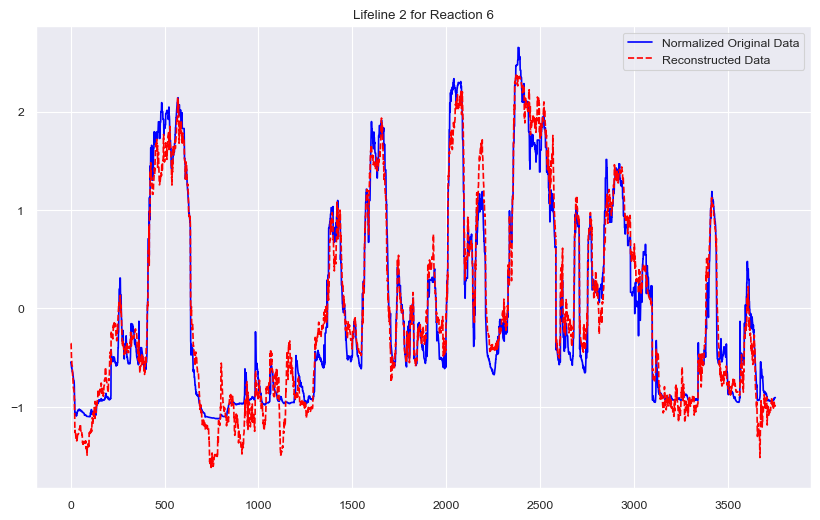

In [9]:
import matplotlib.pyplot as plt

original_data_reshaped = original_data.reshape(original_data.shape[0], original_data.shape[1], 1)
reconstructed_data_2d = autoencoder.predict(original_data_reshaped)

# Reshape reconstructed data back to the original 3D shape
reconstructed_data_3d = reconstructed_data_2d.reshape(data_3d.shape[0], data_3d.shape[1], data_3d.shape[2])

# Extract series for a specific lifeline and reaction
lifeline_index = 2
reaction_index = 6

# Normalized original series
normalized_original_series = data_3d[:, lifeline_index, reaction_index]

# Reconstructed series
reconstructed_series = reconstructed_data_3d[:, lifeline_index, reaction_index]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(normalized_original_series, label='Normalized Original Data', color='blue')
plt.plot(reconstructed_series, label='Reconstructed Data', color='red', linestyle='--')
plt.title(f"Lifeline {lifeline_index} for Reaction {reaction_index}")
plt.legend()
plt.show()


In [11]:
import pandas as pd

# Convert the latent data to a DataFrame
latent_df = pd.DataFrame(latent_data)

# Save to a CSV file
latent_df.to_csv("latent_data_14lifelines.csv", index=False)


In [ ]:
# Save the entire model to a file
autoencoder.save('path_to_14lifeline_autoencoder.h5')  # The .h5 extension indicates a HDF5 file

In [1]:
# Step 1: Create the encoder model
encoder_model = Model(inputs=inp, outputs=latent)

# Step 2: Get the weights of the first layer of the encoder
# (assuming 'encoder' is the first layer of your encoder)
encoder_weights = encoder_model.layers[1].get_weights()[0]

# Step 3: Analyze the weights
# You can use various methods to analyze these weights.
# For example, you can look at the absolute values to see which original features
# contribute most to each latent feature.

# Printing the shape of the weights for understanding
print("Shape of encoder weights:", encoder_weights.shape)

# If you want to visualize the weights for each latent feature
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have a list of names for your original features
feature_names = ['Feature1', 'Feature2', 'Feature3', ...]  # Replace with your actual feature names

for i in range(latent_units):  # Loop over each latent feature
    plt.figure(figsize=(10, 6))
    sns.barplot(x=feature_names, y=encoder_weights[:, i])
    plt.title(f'Feature Contributions to Latent Feature {i}')
    plt.xticks(rotation=45)
    plt.show()


NameError: name 'Model' is not defined